In [35]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from django.db.models import Count, Avg
from multiprocess import Pool
from functools import partial
import numpy as np
from functools import partial
from scipy.sparse import coo_matrix, csr_matrix, find, tril
import networkx as nx

sys.path.append('/home/galm/software/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
qid = 1457

def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

In [30]:
q = Query.objects.get(pk=qid)

mdocs = Doc.objects.filter(
    query=q,
    wosarticle__cr__isnull=False
)

cdos = CDO.objects.filter(
    doc__query=q
)#.values('doc','citation').distinct()

# cdos = CDO.objects.filter(
#     doc__in=mdocs.values_list('UT',flat=True)
# )


m = mdocs.count()
m_dict = dict(zip(
    list(mdocs.values_list('UT',flat=True)),
    list(range(m))
))


rev_m_dict = dict(zip(
    list(range(m)),
    list(mdocs.values_list('UT',flat=True))
))

del mdocs


n = Citation.objects.count()
n_dict = dict(zip(
    list(Citation.objects.all().values_list('id',flat=True)),
    list(range(n))
))

rev_n_dict = dict(zip(
    list(range(n)),
    list(Citation.objects.all().values_list('id',flat=True))

))

print("ROWIDS")
row_ids = list(cdos.values_list('doc__UT',flat=True))
rows = np.array([m_dict[x] for x in row_ids])

print("colids")
col_ids = list(cdos.values_list('citation__id',flat=True))
cols = np.array([n_dict[x] for x in col_ids])

print("data")
data = np.array([1]*cdos.count())

print("matrix")
Scoo = coo_matrix((data, (rows,cols)),shape=(m,n))

del cdos
#del row_ids
#del rows
#del col_ids
#del cols
del n_dict

gc.collect()


S = Scoo.tocsr()
del Scoo
gc.collect()

print("transpose")
St = S.transpose()

print("multiply")
Cmat = S*St


del St
gc.collect()

ltri = tril(Cmat,k=-1)

ROWIDS
colids
data
matrix
transpose
multiply


In [36]:
save_sparse_csr("../networks/1457",ltri.tocsr())

In [32]:
big = ltri.tocsr()[ltri > 200]
print(big)
big = ltri > 200
print(big)

[[238]]
  (153974, 40595)	True


In [29]:
print(data[data > 1])
weird = S > 1
print(S.shape)
print("m = {}, n = {}".format(m,n))
print(m*n)
print(S.getnnz())
print(weird.getnnz())

wf = find(weird)

print(wf[1])
for x in range(weird.getnnz()):
#for x in range(10):
    row = rev_m_dict[wf[0][x]]
    col = rev_n_dict[wf[1][x]]
    cdos = CDO.objects.filter(doc=row,citation=col)
    if cdos.count() > 1:
        cdos.last().delete()


[  18037   25385   28544 ..., 4348092 4348093 4348096]


In [33]:
print(Doc.objects.get(UT=rev_m_dict[153974]).title)
print(Doc.objects.get(UT=rev_m_dict[153974]).cdo_set.count())
print(Doc.objects.get(UT=rev_m_dict[40595]).title)
print(Doc.objects.get(UT=rev_m_dict[40595]).cdo_set.count())

TURNER REVIEW No. 6 - Genetic pollution of native eucalypt gene pools - Identifying the risks (vol 51, pg 1, 2003)
251
Genetic pollution of native eucalypt gene pools - identifying the risks
251


In [32]:
rev_m_dict[23802]
rev_m_dict[7074]

'WOS:000280719700002'

In [35]:
d = Doc.objects.get(pk='WOS:000347944700001')
print(d.title)

WOS:000347944700001


In [16]:
ltri
mat = find(ltri)
edge_n = len(mat[0])

with open("../networks/1457.edgelist","w") as f:

    for i in range(edge_n):
        f.write("{} {} {}\n".format(mat[0][i],mat[1][i],mat[2][i]))

In [17]:
mdocs = Doc.objects.filter(
    query=q,
    wosarticle__cr__isnull=False
)

with open("../networks/1457_nodelabels.txt","w") as f:
    for i in mdocs.iterator():
        f.write("{}\t{}\n".format(i.title,i.UT))
        
        

In [4]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from scipy.sparse.csgraph import *

In [5]:
#af = AffinityPropagation(preference=-50).fit(ltri)

length
1         8040
2          190
3           37
4            3
5            4
7            1
141137       1
dtype: int64


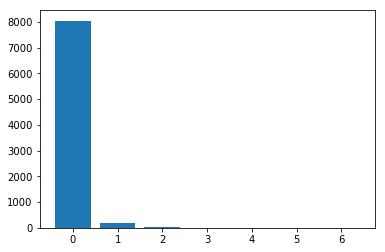

In [6]:

N_components, component_list = connected_components(ltri, directed=False)

clist = [np.sum(component_list == i) for i in range(N_components)]
df = pd.DataFrame({"length": clist})
sizes = df.groupby("length", as_index=False).size()
labels = [str(x) for x in sizes.index]
print(sizes)
#sizes = sizes.reindex(drop=True)

plt.bar(list(range(len(sizes))),sizes.values)
plt.show()

In [7]:
df[df['length']==141137].index

Int64Index([0], dtype='int64')

In [16]:
nodes = []
for i in range(len(component_list)):
    if component_list[i]==0:
        nodes.append(i)
connected_graph = ltri.tocsr()[nodes, :].tocsc()[:,nodes]
connected_graph

<141137x141137 sparse matrix of type '<class 'numpy.int64'>'
	with 30244903 stored elements in Compressed Sparse Column format>

In [ ]:
af = AffinityPropagation().fit(connected_graph)

In [ ]:
distances, predecessors = dijkstra(ltri, return_predecessors=True)


In [ ]:
gsize = 10000
small_graph = ltri.tocsc()[0:gsize,0:gsize]
distances, predecessors = dijkstra(small_graph, return_predecessors=True)

In [1]:
gsize = 10000
small_graph = ltri.tocsc()[0:gsize,0:gsize]
N_components, component_list = connected_components(ltri, directed=False)

clist = [np.sum(component_list == i) for i in range(N_components)]
df = pd.DataFrame({"length": clist})
sizes = df.groupby("length", as_index=False).size()
labels = [str(x) for x in sizes.index]
print(sizes)
#sizes = sizes.reindex(drop=True)

plt.bar(list(range(len(sizes))),sizes.values)
plt.show()

NameError: name 'ltri' is not defined

In [ ]:
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

In [ ]:
print(labels)
clist = [np.sum(labels == i) for i in range(n_clusters_)]
df = pd.DataFrame({"length": clist})
sizes = df.groupby("length", as_index=False).size()
print(sizes)
#sizes = sizes.reindex(drop=True)

plt.bar(list(range(len(sizes))),sizes.values)
plt.show()

In [ ]:
df[df['length']==51].index

In [ ]:
nodes = []
for i in range(len(labels)):
    if labels[i]==446:
        nodes.append(i)
nodes

In [ ]:
doc_ids = [Doc.objects.get(pk=rev_m_dict[i]).title for i in nodes]
doc_ids